In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Ride Analysis: Frequency-Domain Response to Road Inputs

For the frequency response analysis of vehicles, quarter-car suspension models are generally used due to their simplicity. The quarter-car model's schematic is in the main page of the repository.

Here

$z_\text{s}$ = sprung mass displacement\
$z_\text{u}$ = unsprung mass displacement\
$z_\text{r}$ = road elevation\
$m_\text{s}$ = sprung mass\
$m_\text{u}$ = unsprung mass\
$k_\text{s}$ = suspension stiffness (assumed linear here)\
$k_\text{t}$ = tire stiffness (assumed linear here)\
$c_\text{s}$ = suspension damping coefficient (assumed linear here)

To get the frequency-domain response of the suspension to a given road input, we can use the following relationship [Gillespie, 1992]:


$$ \Phi_\text{zs}(f) = |G_\text{sr}(f)|^2 \Phi_\text{zr}(f) $$

where

$\Phi_\text{zs}(f)$ = Acceleration PSD of the sprung mass at frequency $f$\
$G_\text{sr}(f)$ = Acceleration response gain of the vehicle for $\ddot{z}_s/\ddot{z}_r$\
$\Phi_\text{zr}(f)$ = Acceleration PSD of the road input at frequency $f$

**PSD stands for power spectral density

The steps involved in this analysis are as follows:
1. Create the acceleration response gain model (transfer function) from the equations of motion
2. Obtain the PSD of the road under study (generally we use random roads)
3. Obtain the PSD of the acceleration of the sprung mass using the above equation

### Quarter-Car Suspension Equations of Motion

The equations of motions for the quarter-car suspension model are [Gillespie, 1992]:

$$ m_\text{s}\ddot{z}_\text{s} + c_\text{s}\dot{z}_\text{s} + k_\text{s} z_\text{s} - c_\text{s} \dot{z}_\text{u} + k_\text{s} z_\text{u} = 0 $$ 
$$ m_\text{u}\ddot{z}_\text{u} + c_\text{s} \dot{z}_\text{u} + (k_\text{s} + k_\text{t}) z_\text{u} - c_\text{s} \dot{z}_\text{s} - k_\text{s} z_\text{s} - k_\text{t} z_\text{r}= 0$$ 


### Step 1: Gain Transfer Functions:

To perform the frequency-domain analysis, the equations of motion are transformed into the frequency domain by taking the Laplace transform from the above equations. After re-arranging the terms, the gain (transfer function) equation becomes [Gillespie, 1992]:


$$ G_\text{sr}(\omega) = \frac{\ddot{z}_\text{s}}{\ddot{z}_\text{r}} = \frac{K_\text{t} K_\text{s} + j [K_\text{t} C \omega]}{[ M \omega^4 - (K_\text{t}+K_\text{s} M+K_\text{s})\omega^2 + K_\text{t} K_\text{s}] +j[K_tC\omega-(1+M)C\omega^3 ] } $$

where

$ M  = m_\text{u}/m_\text{s} $\
$ K_\text{s} = k_\text{s}/m_\text{s} $\
$ K_\text{t} = k_\text{t}/m_\text{s}$\
$ C = c_\text{s}/m_\text{s}$\
$ j $ = complex number operator\
$\omega$ = frequency in (rad/s), which can be obtained from the spatial frequency of the road $\Omega$ times the travel velocity of the vehicle as follows:

$$ \omega [rad/s] = \Omega [rad/m] \times v_{veh} [m/s] $$



In [2]:
def get_Gsz_gain(omega, p):
    """
    Returns the transfer function value for the acceleration gain of the sprung mass.
    
    Parameters:
    ---------
    omega: ndarray
        frequency array in [rad/s]   
    p: ndarray, shape(5,)
        Parameter of the vehicle
       
    Returns:
    -------
    omega: ndarray
        Frequency array in [rad/s]
    gain: ndarray
        Gain values 
        
    """    
    sprung_mass          = p[0]
    unsprung_mass        = p[1]
    suspension_stiffness = p[2]
    suspension_damping   = p[3]
    tire_stiffness       = p[4]
    
    M  = unsprung_mass/sprung_mass
    Kt = tire_stiffness/sprung_mass
    Ks = suspension_stiffness/sprung_mass
    C  = suspension_damping/sprung_mass
    w  = omega
    
    gain = (Kt*Ks+(Kt*C*w)*1j)/((M*w**4-(Kt+Ks*M+Ks)*w**2+Kt*Ks)+(Kt*C*w-(1+M)*C*w**3)*1j)

    return omega, np.abs(gain)

### Step 2: Road Generation (ISO Random Road)

Random road profiles can be modeled via a superposition of $N->\infty$ sine waves as follows [Rill and Castro, 2020]:

$$ z_\text{r}(x) = \sum_{i = 1}^N A_i \text{sin}(\Omega_i x - \Psi_i) $$ 

where

$z_\text{r}(x)$ = Road elevation at position $x$\
$A_i$ = i-th sinewave's amplitude\
$N$ = Number of sinwaves\
$\Omega_i$ = i-th sinewave's wavenumber (spatial frequency in [rad/m])\
$\Psi_i$ = i-th sinewave's uniformly distributed phase angle between 0 and $2\pi$  [rad]

Here

$A_i = \sqrt{2\Phi(\Omega_i)\Delta\Omega} \quad [m] \quad i = 1, \ldots, N$

where $\Omega_i$'s are equally distaned between $\Omega_{max}$ (maximum wavenumber) and $\Omega_{min}$ (minium wavenumber) by the step size of $\Delta\Omega$. 

$\Phi(\Omega_i)$ is the PSD value of road profile at wavenumber $\Omega_i$. To obtain this for a typical random road, we can use the following PSD estimate from [Rill and Castor, 2022]:

$$ \Phi(\Omega_i) = \Phi(\Omega_0) (\Omega_i/\Omega_0)^{-w} \quad i = 1, \ldots, N$$

where $\Omega_0 = 1$ is the reference wavenumber and waviness is $ w= 2$. 

The acceleration of road input $\ddot{z}_\text{r}$ is evaluated by taking the second time derivative of $z_\text{r}$.

### ISO Random Road Generation

In [3]:
def generate_iso_random_road(N, L_max, L_min, Phi_0, v_veh, t0, tf, n_t):
    """
    Returns ISO random road elevation and acceleration.
    
    Parameters:
    ---------
    N: int
        Number of sinusoidal terms for road generation   
    L_max: float
        Maximum wavelength of the waves [m]
    L_min: float
        Minimum wavelength of the waves [m]
    Phi_0: float
        Road profile PSD at the reference wavenumber, value based on ISO 8608 [m^2/rad/m]
    v_veh: float
        Vehicle travel velocity in [m/s]
    t0: float
        Start time of travel in [s]
    tf: float
        End time of travel in [s]
    n_t: int
        Number of time stamps
       
    Returns:
    -------
    t: numpy.ndarray
       Time array for the road
    z_r: numpy.ndarray
        Road height array in [m]
    ddz_r: numpy.ndarray
        Road input acceleration in [m/s^2]
    sampling_rate: float
        The sampling rate of the generated signals
    """                     

    # Common parameters                     
    Omega_0     = 1 # reference wavenumber [rad/m] 
    w           = 2 # general value for waviness

    Omega_min   = 2*np.pi/L_max # min wavenumber [rad/m]
    Omega_max   = 2*np.pi/L_min # max wavenumber [rad/m]
    delta_Omega = (Omega_max - Omega_min)/(N-1)
    Omega       = np.arange(Omega_min, Omega_max, delta_Omega)

    Phi         = Phi_0*(Omega/Omega_0)**(-w)
    A           = np.sqrt(2*Phi*delta_Omega) # [m] amplitudes

    # Uniformly distributed phase angles
    np.random.seed(10)
    Psi         = np.random.uniform(low=0.0, high=2*np.pi, size=(N,1))
    
    # Travel time
    t           = np.linspace(t0, tf, n_t)

    sampling_rate = (n_t-1)/ (tf-t0) # number of samples in a given time [samples/second]
    
    z_rn        = np.zeros((N,n_t))    
    for n in range(N-1):
        z_rn[n] = A[n]*np.sin(Omega[n]*v_veh*t + Psi[n])    
    z_rn.squeeze()
    z_r = np.sum(z_rn, axis = 0)

    # Calculate the acceleration input via diff of the elevation input
    dt    = t[2]-t[1]
    dz_r  = np.diff(z_r)/dt # first derivative (road velocity input) [m/s]
    # Note that the derivate of the last point is not accurate. 
    # It has been equated to the derivate of its adjacent point.
    # For this analysis, this is fine as the effect of the last point is not that prominent.
    # Using techniques such as central difference can address this.
    dz_r  = np.append(dz_r, dz_r[-1]) 
    
    ddz_r = np.diff(dz_r)/dt # second derivative (road acceleration input) [m/s^2]
    ddz_r = np.append(ddz_r, ddz_r[-1])
    
    return t, z_r, ddz_r, sampling_rate, Omega

### Power Spectral Density Calculation
To get the PSD of the road, we are using the fft method of the numpy package.

In [4]:
def compute_psd(signal, sampling_rate):
    """
    Calculate the one-sided Power Spectral Density (PSD) of a signal.

    Parameters:
    ----------
    signal: array_like
        Input signal array
    sampling_rate : float
        Sampling rate of the signal (in Hz).

    Returns:
    --------
    frequencies: array_like
        The array of frequencies.
    psd: array_like
        One-sided power spectral density of the signal.
    """  

    # Calculate FFT of the signal
    fft_values = np.fft.fft(signal)

    # Calculate frequencies corresponding to FFT values
    frequencies = np.fft.fftfreq(len(signal), d=1/sampling_rate)

    # Find indices corresponding to positive frequencies (one-sided)
    positive_freq_indices = np.where(frequencies >= 0)

    # Take a one-sided FFT result
    one_sided_fft = fft_values[positive_freq_indices]

    # Take absolute value squared to get power spectral density
    psd = np.abs(one_sided_fft)**2

    # Scale PSD by the sampling frequency to get the correct power units 
    psd /= sampling_rate
    
    return frequencies[positive_freq_indices], psd

### Step 3: Obtain the Vehicle Response 
Use the below equation to obtain the sprung mass spectral response:

$$ \Phi_\text{zs}(f) = |G_\text{sr}(f)|^2 \Phi_\text{zr}(f) $$

In [7]:
# Road Generation Parameters
N     = 500  # number of sinewaves or frequencies
L_max = 100  # maximum wavelength for road roughness [m]
L_min = 0.1  # minimum wavelength for road roughnes  [m]
Phi_0 = 1e-6 # Road roughness based on ISO 8608      [m^2/rad/m]

# Vehicle Parameters
v_veh = 50/3.6 # vehicle velocity [kph] -> [m/s]
ms_val = 500
mu_val = 50
ks_val = 30000
cs_val = 1000
kt_val = 150000
p_vals = [ms_val, mu_val, ks_val, cs_val, kt_val]

# Travel Parameters
t0    = 0    # start time
tf    = 10  # end time
n_t   = 500  # number of time stamps

# Obtain the values
times, z_signal, ddz_signal, sampling_rate, Omega = generate_iso_random_road(N, L_max, L_min, Phi_0, v_veh, t0, tf, n_t)
ddz_r_signal_g                                    = ddz_signal/9.81 # to convert [m/s^2] -> [g]
freq, z_r_psd                                     = compute_psd(z_signal, sampling_rate);
freq, ddz_r_psd                                   = compute_psd(ddz_r_signal_g, sampling_rate);
omega, gain                                       = get_Gsz_gain(freq*2*np.pi, p_vals) # freq [Hz]->[rad/s]
# Obtain the vehicle spectral vehicle response
veh_acc_psd                                       = gain**2*ddz_r_psd

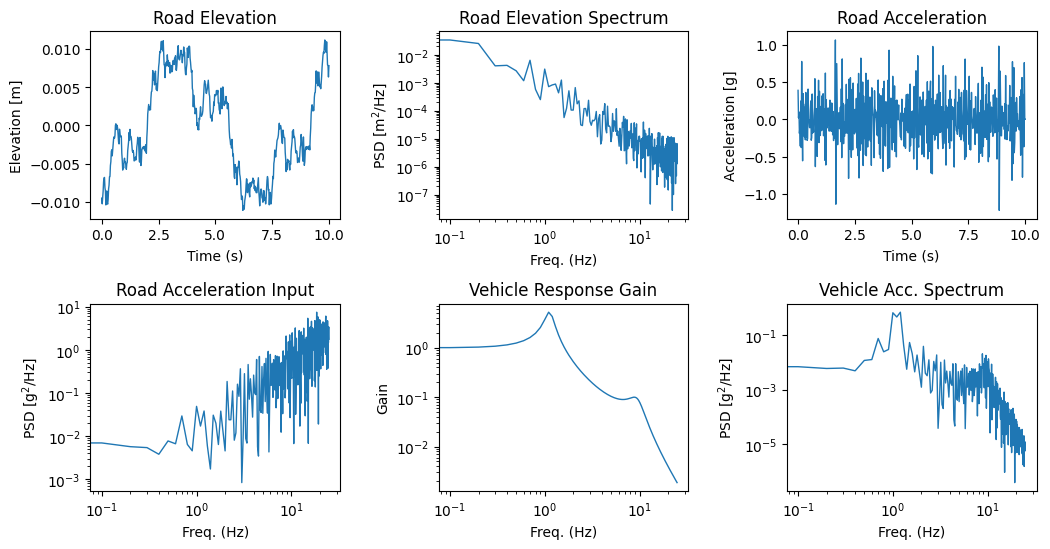

In [8]:
fig, ax = plt.subplots(2,3,figsize=(11, 6))
fig.tight_layout(pad=4)

ax[0,0].plot(times, z_signal, linewidth = 1)
ax[0,0].set_ylabel('Elevation [m]')
ax[0,0].set_title('Road Elevation')
ax[0,0].set_xlabel('Time (s)')

ax[0,1].loglog(freq, z_r_psd, linewidth = 1)
ax[0,1].set_ylabel('PSD [$\\mathrm{m^2/Hz}$]')
ax[0,1].set_title('Road Elevation Spectrum')
ax[0,1].set_xlabel('Freq. (Hz)')

ax[0,2].plot(times, ddz_r_signal_g, linewidth = 1)
ax[0,2].set_title('Road Acceleration')
ax[0,2].set_ylabel('Acceleration [g]')
ax[0,2].set_xlabel('Time (s)')

ax[1,0].loglog(freq, ddz_r_psd, linewidth = 1)
ax[1,0].set_title('Road Acceleration Input')
ax[1,0].set_ylabel('PSD [$\\mathrm{g^2/Hz}$]')
ax[1,0].set_xlabel('Freq. (Hz)')

ax[1,1].loglog(freq, gain, linewidth = 1)
ax[1,1].set_title('Vehicle Response Gain')
ax[1,1].set_ylabel('Gain')
ax[1,1].set_xlabel('Freq. (Hz)')

ax[1,2].loglog(freq, veh_acc_psd, linewidth = 1)
ax[1,2].set_title('Vehicle Acc. Spectrum')
ax[1,2].set_ylabel('PSD [$\\mathrm{g^2/Hz}$]')
ax[1,2].set_xlabel('Freq. (Hz)');

### References
- Gillespie, T. (1992). Fundamentals of vehicle dynamics. SAE international.
- Rill, G., & Castro, A. A. (2020). Road vehicle dynamics: fundamentals and modeling with MATLAB®. CRC Press.